In [1]:
import os
from matrix_client.api import MatrixHttpApi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matrixstats import get_all_events, get_rooms_in_community, filter_events_by_messages, get_display_names
from matrixstats import print_sorted_len, print_sorted_value, flatten_dicts

In [2]:
with open(".matrix_token") as f:
    token = str(f.read()).strip()

homeserver = "https://matrix.cadair.com"

api = MatrixHttpApi(homeserver, token=token)

In [3]:
ids = get_rooms_in_community(api, "+astropy:openastronomy.org")
ids = {'astropy': get_rooms_in_community(api, "+astropy:openastronomy.org"),
       'sunpy': get_rooms_in_community(api, "+sunpy:openastronomy.org")}

In [4]:
# Get all the messages in all the rooms
events = {group: get_all_events(api, cids, cache=f"{group}_messages.h5", refresh_cache=False)
          for group, cids in ids.items()}

# Pop out this chat as it's old and full of freenode spam
_ = events['astropy'].pop("astropy_irc_and_gitter")
# Pop out this one as it has no messages in it
#_ = events['astropy'].pop("astropy_workshops")
_ = events['astropy'].pop("astropy_matrix_test")

# Filter by actual messages
messages = {group: filter_events_by_messages(gevents) for group, gevents in events.items()}

for gmessages in messages.values():
    for m in gmessages.values():
        m.loc[:,'usender'] = [a.split(":")[0][1:].split("_")[-1] if "slack" in a else a for a in m['sender']]

In [5]:
all_messages = {group: pd.concat(gmessages).reset_index(level=0) for group, gmessages in messages.items()}

# Instant Messaging

All public channels in astropy.slack.org is bridged to chat.openastronomy.org

Matrix keeps all history which can requested from any matrix server in the room.

https://view.matrix.org/alias/%23astropy_general:openastronomy.org

Therefore... STATISTICS!

https://github.com/cadair/chat_stats

# Number of Channels

In [6]:
len(messages['astropy'])

37

# Number of Messages per Channel

In [7]:
def get_len_key(adict, reverse=True):
    n_messages = {}
    for k in sorted(adict, key=lambda k: len(adict[k]), reverse=reverse):
        m = adict[k]
        n_messages[k] = len(m)
    return n_messages

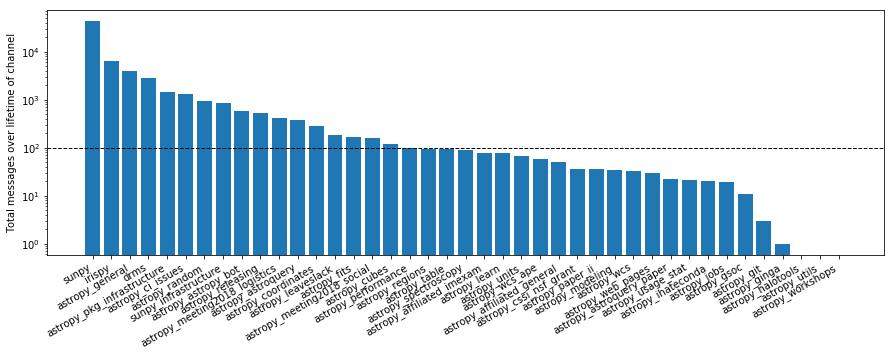

In [8]:
fig = plt.figure(figsize=(15,5))
n_messages = get_len_key(flatten_dicts(messages))
plt.bar(list(range(len(n_messages))), list(n_messages.values()), tick_label=list(n_messages.keys()))
fig.autofmt_xdate()
plt.axhline(100, linestyle="--", linewidth=1, color="k")
plt.semilogy()
_ = plt.ylabel("Total messages over lifetime of channel")

In [9]:
print_sorted_len(flatten_dicts(messages))

sunpy: 42817
irispy: 6495
astropy_general: 3974
drms: 2777
astropy_pkg_infrastructure: 1417
astropy_ci_issues: 1331
astropy_random: 949
sunpy_infrastructure: 842
astropy_astropy_bot: 586
astropy_releasing: 527
astropy_meeting2018_logistics: 418
astropy_astroquery: 377
astropy_coordinates: 280
astropy_leaveslack: 181
astropy_fits: 164
astropy_meeting2018_social: 160
astropy_cubes: 121
astropy_performance: 97
astropy_regions: 94
astropy_table: 94
astropy_spectroscopy: 89
astropy_affiliated_imexam: 79
astropy_learn: 78
astropy_units: 66
astropy_wcs_ape: 58
astropy_affiliated_general: 50
astropy_cssi_nsf_grant: 36
astropy_paper_ii: 36
astropy_modeling: 34
astropy_wcs: 33
astropy_web_pages: 30
astropy_astroquery_paper: 22
astropy_usage_stat: 21
astropy_ihateconda: 20
astropy_jobs: 19
astropy_gsoc: 11
astropy_git: 3
astropy_ginga: 1
astropy_halotools: 0
astropy_utils: 0
astropy_workshops: 0


In [10]:
channel_creation = {k:v.index[-1] for k, v in flatten_dicts(events).items()}

print_sorted_value(channel_creation, reverse=False)

sunpy: 2016-09-30 04:58:02.321000
drms: 2017-05-08 08:43:39.456000
irispy: 2017-05-22 09:04:46.728000
astropy_general: 2017-09-25 11:22:20.701000
astropy_pkg_infrastructure: 2018-02-22 04:49:41.385000
sunpy_infrastructure: 2018-04-23 06:33:35.460000
astropy_affiliated_general: 2018-04-23 12:16:38.211000
astropy_astropy_bot: 2018-04-23 12:16:39.906000
astropy_astroquery: 2018-04-23 12:17:28.238000
astropy_astroquery_paper: 2018-04-23 12:18:43.243000
astropy_ci_issues: 2018-04-23 12:19:38.246000
astropy_coordinates: 2018-04-23 12:21:18.240000
astropy_cssi_nsf_grant: 2018-04-23 12:22:08.239000
astropy_fits: 2018-04-23 12:22:58.238000
astropy_git: 2018-04-23 12:24:28.232000
astropy_gsoc: 2018-04-23 12:25:13.238000
astropy_halotools: 2018-04-23 12:26:03.241000
astropy_jobs: 2018-04-23 12:27:33.243000
astropy_learn: 2018-04-23 12:28:23.232000
astropy_paper_ii: 2018-04-23 12:29:58.235000
astropy_performance: 2018-04-23 12:30:43.245000
astropy_random: 2018-04-23 12:32:23.252000
astropy_regions

In [11]:
messages_per_day = {group: pd.DataFrame({k:m['body'].resample("1D").count() for k,m in gm.items() if not m.empty})
                    for group, gm in messages.items()}

In [12]:
messages_per_week = {group: pd.DataFrame({k:m['body'].resample("1W").count() for k,m in gm.items() if not m.empty})
                     for group, gm in messages.items()}

In [13]:
total_mpd = {group: df.sum(axis=1) for group, df in messages_per_day.items()}
total_mpw = {group: df.sum(axis=1) for group, df in messages_per_week.items()}

## Total Messages per Week

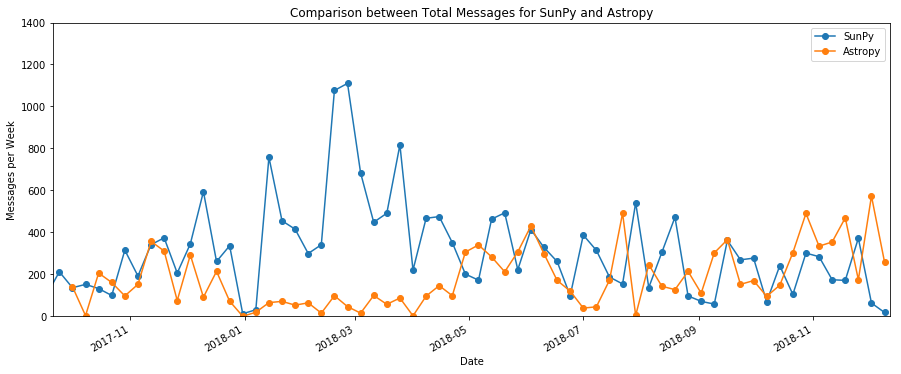

In [14]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total_mpw['sunpy'].index, total_mpw['sunpy'], "-o", label="SunPy")
ax.plot(total_mpw['astropy'].index, total_mpw['astropy'], "-o", label="Astropy")
fig.autofmt_xdate()
plt.legend()
ax.set_ylabel("Messages per Week")
ax.set_xlabel("Date")
ax.axis((736592.85, 737040.15, 0.0, 1400))
ax.set_title("Comparison between Total Messages for SunPy and Astropy")
None

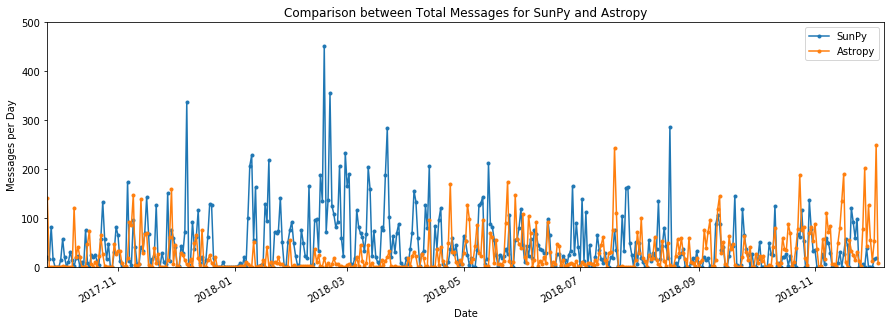

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Comparison between Total Messages for SunPy and Astropy")

ax.plot(total_mpd['sunpy'].index, total_mpd['sunpy'], "-o", ms=3, label="SunPy")
ax.plot(total_mpd['astropy'].index, total_mpd['astropy'], "-o", ms=3, label="Astropy")

fig.autofmt_xdate()
plt.legend()

ax.set_ylabel("Messages per Day")
ax.set_xlabel("Date")
ax.axis((736596.85, 737035.15, 0.0, 500))
None

## Most Active Senders

In [16]:
total_senders = {group: {k: m.groupby("usender").count()['body'] for k,m in gm.items()}
                 for group, gm in messages.items()}

In [17]:
active_senders = {}
for group, gmessages in all_messages.items():
    senders = pd.DataFrame(gmessages.groupby("usender").count()['body'].sort_values(ascending=False))
    senders = senders[:20]

    senders['display_name'] = get_display_names(api, senders.index, "@slack_astropy_{s}:openastronomy.org")

    senders = senders.reset_index()
    senders = senders.set_index("display_name")
    _ = senders.pop("usender")
    senders = senders.groupby(senders.index).sum().sort_values(by='body', ascending=False)
    active_senders[group] = senders

In [18]:
active_senders['astropy']

,body
display_name,
bsipocz,2316
Cadair*,1981
pllim,1599
astrofrog,1373
dan,510
eteq,503
adamginsburg,499
saimn,364
adrn,257


In [22]:
active_senders['sunpy']

,body
display_name,
Cadair*,18569
Nabobalis*,6265
DanRyan37*,4238
DavidPS*,2850
abit2*,2433
itachi_uchiha_*,1810
itachi_uchiha_ (IRC)*,1364
nitinkgp23*,1275
vn-ki*,1230


# Senders per Week

In [19]:
senders_per_day = {group: am.resample("1D").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}
senders_per_week = {group: am.resample("1W").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}

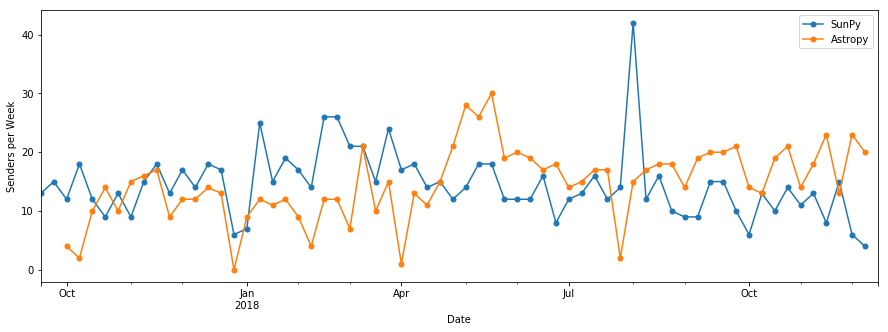

In [20]:
fig, ax = plt.subplots(figsize=(15,5))

senders_per_week['sunpy'].plot(ax=ax, label="SunPy", style="o-", ms=5)
senders_per_week['astropy'].plot(ax=ax, label="Astropy", style="o-", ms=5)
ax.set_ylabel("Senders per Week")
ax.set_xlabel("Date")
plt.xlim((2490, 2555))
_ = plt.legend()

## Messages per Day vs Senders per Day

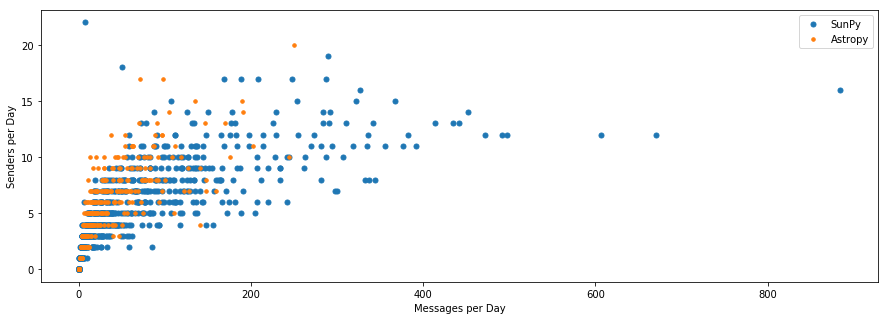

In [21]:
plt.figure(figsize=(15,5))
sp = plt.plot(total_mpd['sunpy'], senders_per_day['sunpy'], ".", color="C0", ms=10)
ap = plt.plot(total_mpd['astropy'].reindex(senders_per_day['astropy'].index),
              senders_per_day['astropy'], ".", color="C1", ms=7)
plt.xlabel("Messages per Day")
plt.ylabel("Senders per Day")
plt.legend((sp[0], ap[0]), ("SunPy", "Astropy"))